# Hamming distance histograms

Local and global Hamming distance superimposed. 
- Local: the surface of the neutral space 
- Global: the total genotypes in the map

No deleterious ignores the gneotypes of phenotype '.'*L

In [10]:
import pickle 
with open("../data/hammingglobalDPD_nodel.pkl","rb") as f:
    hammingglobalDPD = pickle.load(f)
with open("../data/hamminglocalDPD_nodel.pkl","rb") as f:
    hamminglocalDPD = pickle.load(f)
with open("../data/edgeD.pkl","rb") as f:
    edgeD = pickle.load(f)
with open("../data/neutralsets.pkl","rb") as f:
    neutralsets = pickle.load(f)
L=12
K=4

In [7]:
from collections import defaultdict
sort_neutralsets = defaultdict(float)
sorted_neutralsets = dict(sorted(neutralsets.items(), key=lambda item: item[1], reverse=True))
for k, v in sorted_neutralsets.items():
    k = k.replace('\n', '')
    sort_neutralsets[k] = v

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


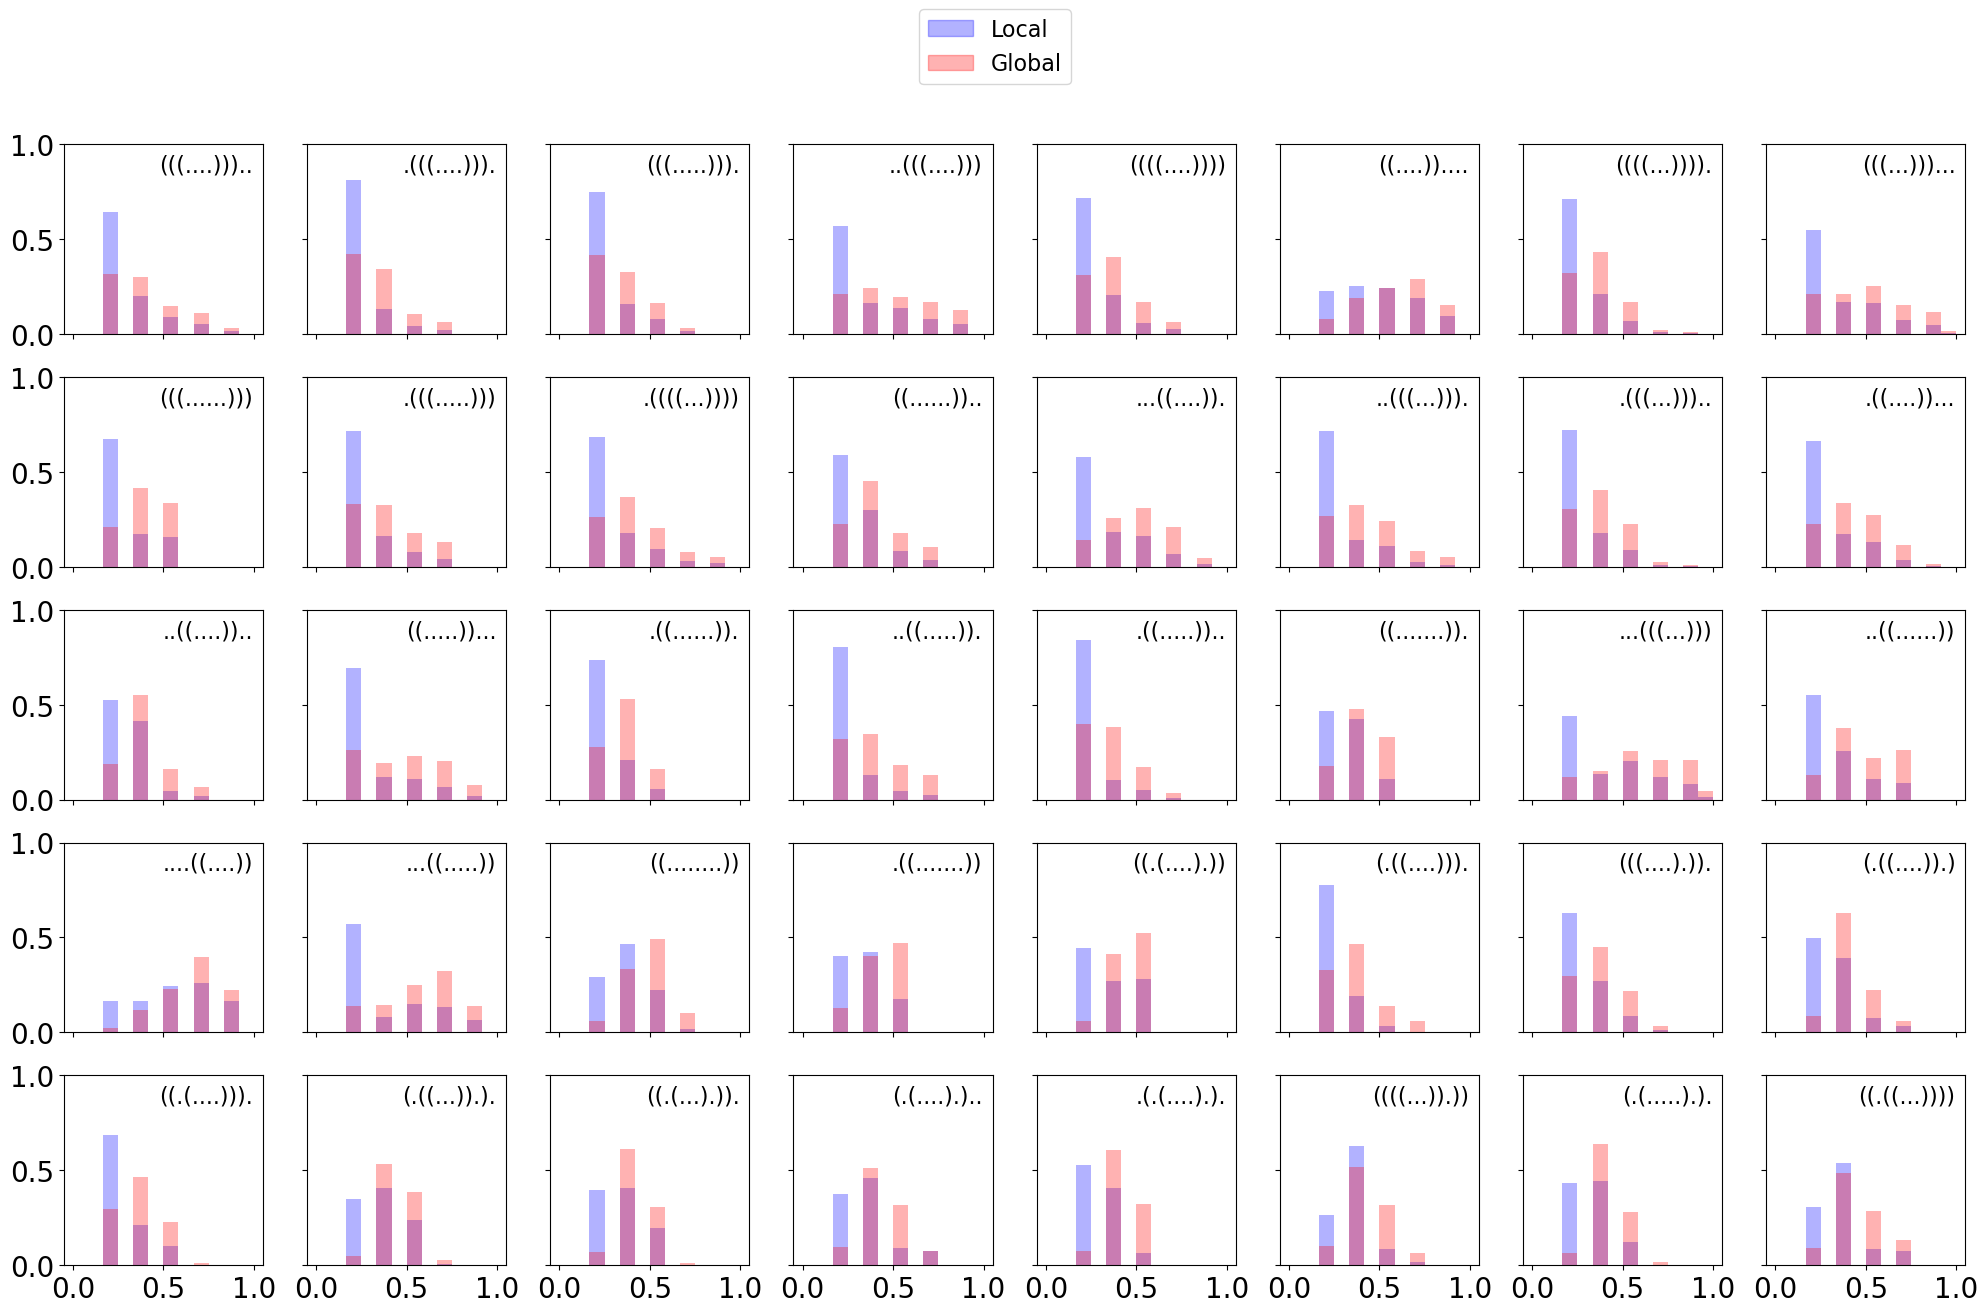

In [51]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

fig, axs = plt.subplots(5, 8, figsize=(20, 12), sharex=True, sharey=True)  # 5 rows, 8 columns

bins = np.linspace(0, 1, L+1)


for i, ax in enumerate(axs.flatten()):
    if i < len(hamminglocalDPD):
        key = list(sort_neutralsets.keys())[i+1]

        h_values = list(hamminglocalDPD[key].keys())
        counts = list(hamminglocalDPD[key].values())
        
        ax.hist(h_values, bins=bins, weights=np.array(counts)/(edgeD[key]), color='blue', alpha=0.3)
        
        h_values1 = list(hammingglobalDPD[key].keys())
        counts1 = np.array(list(hammingglobalDPD[key].values()))/np.sum(list(sort_neutralsets.values())[1:])
        
        ax.hist(h_values1, bins=bins, weights=np.array(counts1), color='red', alpha=0.3)
        
        ax.text(0.95, 0.95, key, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=16)
        ax.set_yticks([0.0,0.5,1.0])
        ax.set_xticks([0.0,0.5,1.0])
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size


blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='Local')
red_patch = mpatches.Patch(color='red', alpha=0.3, label='Global')
fig.legend(handles=[blue_patch, red_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=16)
plt.tight_layout()
plt.savefig("hamming.png", bbox_inches='tight')
plt.savefig("hamming.eps", bbox_inches='tight')
plt.show()

# $\phi_{pq}$ with Hamming distance

The $\phi_{pq}$ is the probability of phenotype $q$ mutating to a phenoytpe $p$:

$\sum_p \phi_{pq}$ = 1 

We check that probabilities are higher for similar phenotypes.

Colormap divides warm to cool, with cool colours corresponding to similar phenotypes (low $H$) and  warm colours to less similar (high $H$), normalised from 0-1 with $H-0.5$ as the midpoint for the normalised colormap.

We skip the deleterious and the neutral set.

In [11]:
import pickle
with open("../data/phipq.pkl","rb") as f:
    phipq = pickle.load(f)

L=12
K=4

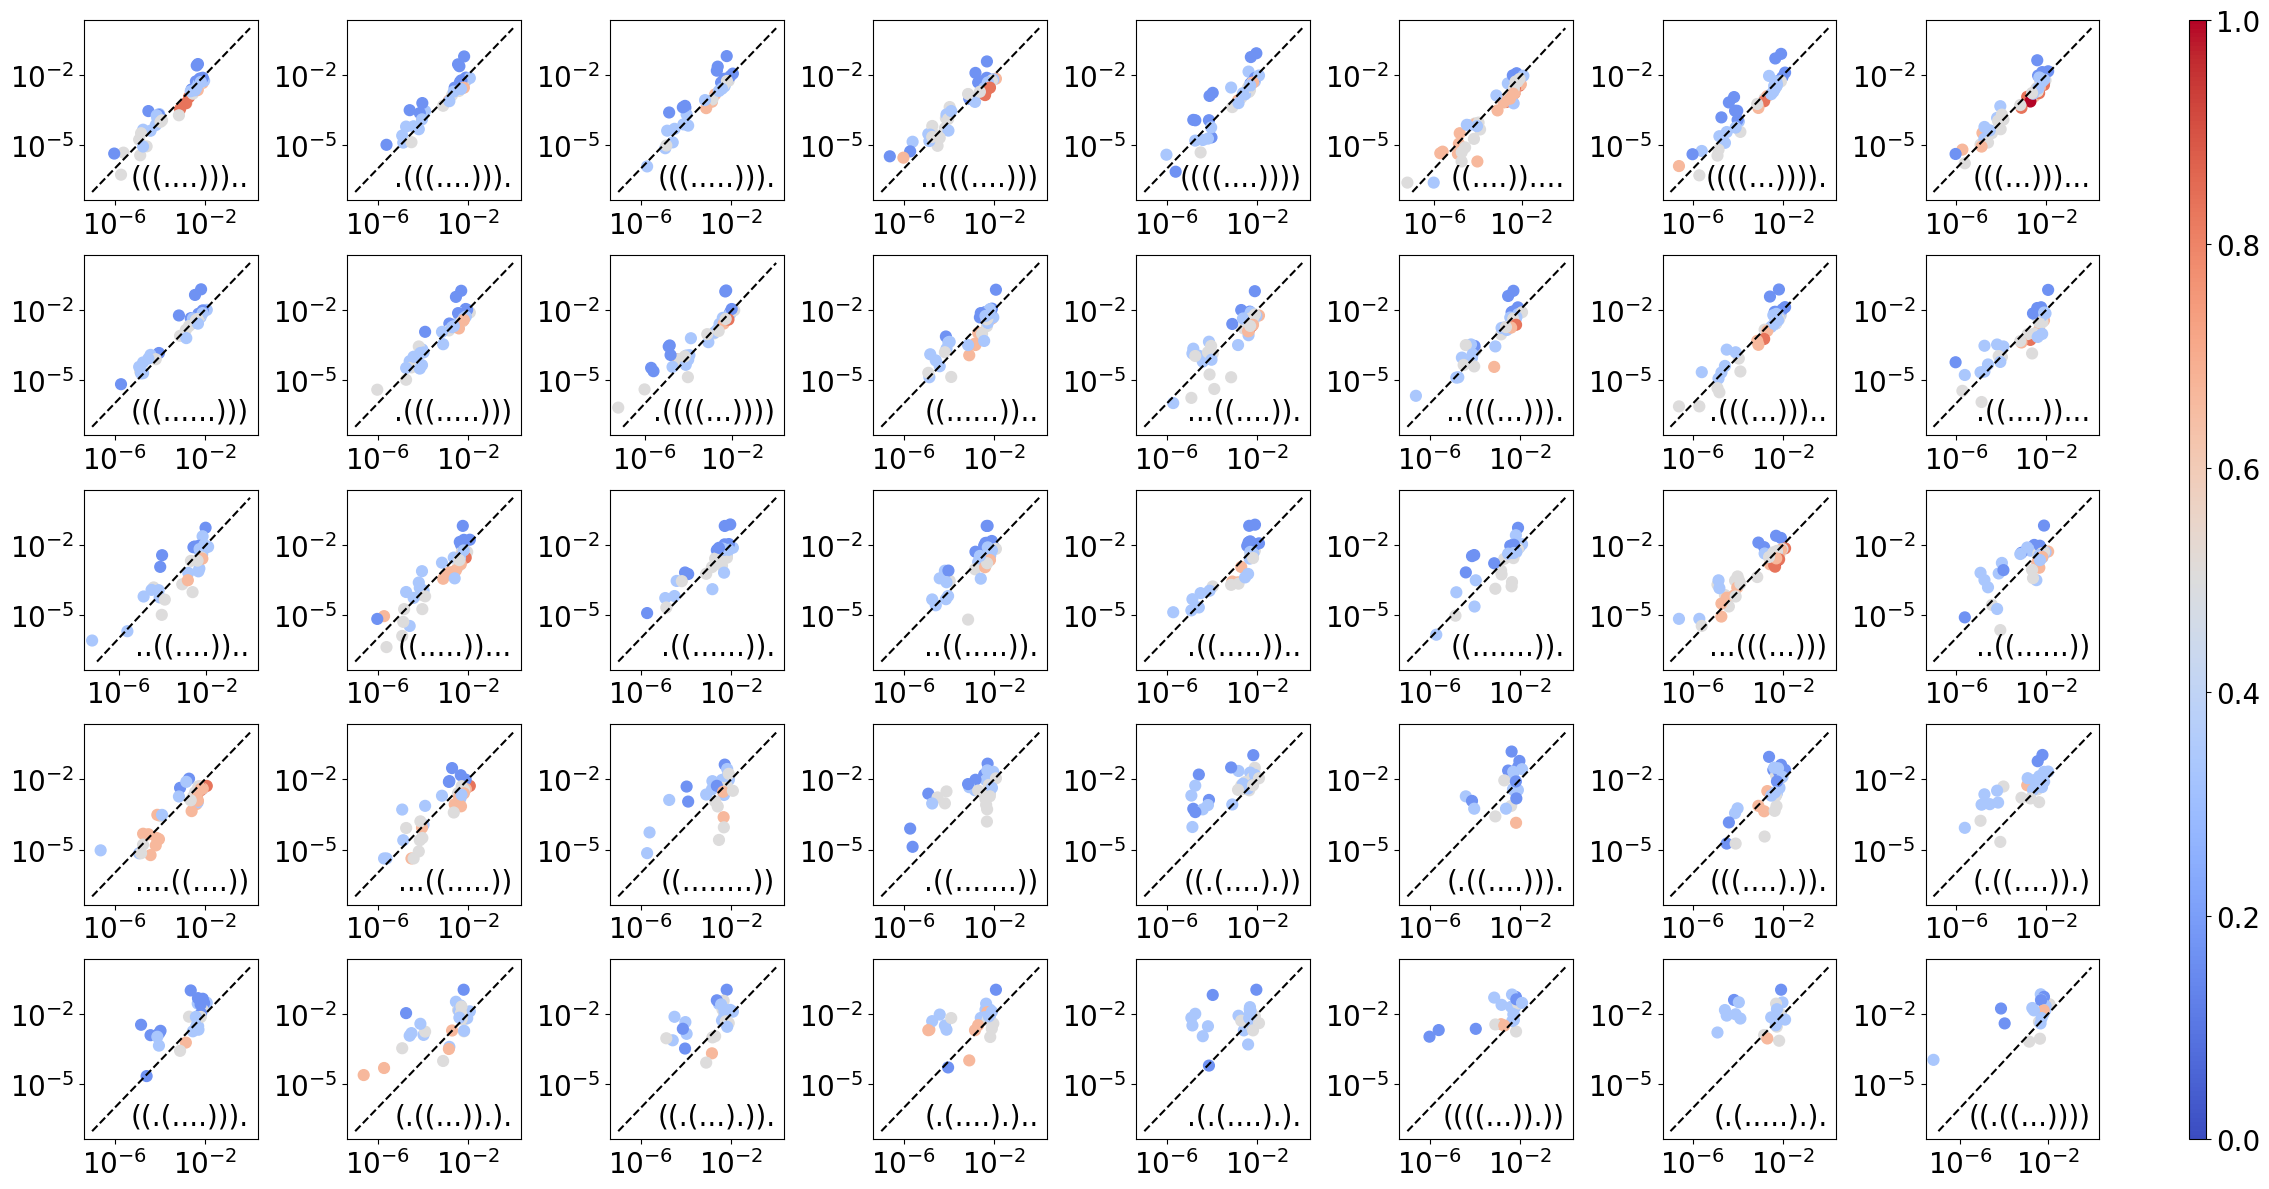

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(5, 9, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.1])

plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

axs = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(8)]

for i, ax in enumerate(axs):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listhamming = []
        listfreq = []
        
        for q, phi in qitems.items():
            if q == '.'*L or q == key:  # Skip the neutral set and the del sequence
                continue
            listphipq.append(phi)
            listhamming.append(hamming(key, q))
            listfreq.append(neutralsets[q+'\n'] / K**L)
        
        scatter = ax.scatter(listfreq, listphipq, s=60, c=listhamming, cmap=cmap, norm=norm, alpha=1)  # Use the colormap to determine the color

        ax.plot([1e-7, 1], [1e-7, 1], color='black', linestyle='--')
        ax.set_xscale("log")
        ax.set_yscale('log')
        ax.set_xticks([1e-6, 1e-2])
        ax.text(0.95, 0.05, key, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_subplot(gs[:, -1])  # Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the colorbar
plt.savefig("phipq.png", bbox_inches='tight')
plt.savefig("phipq.eps", bbox_inches='tight')
plt.show()

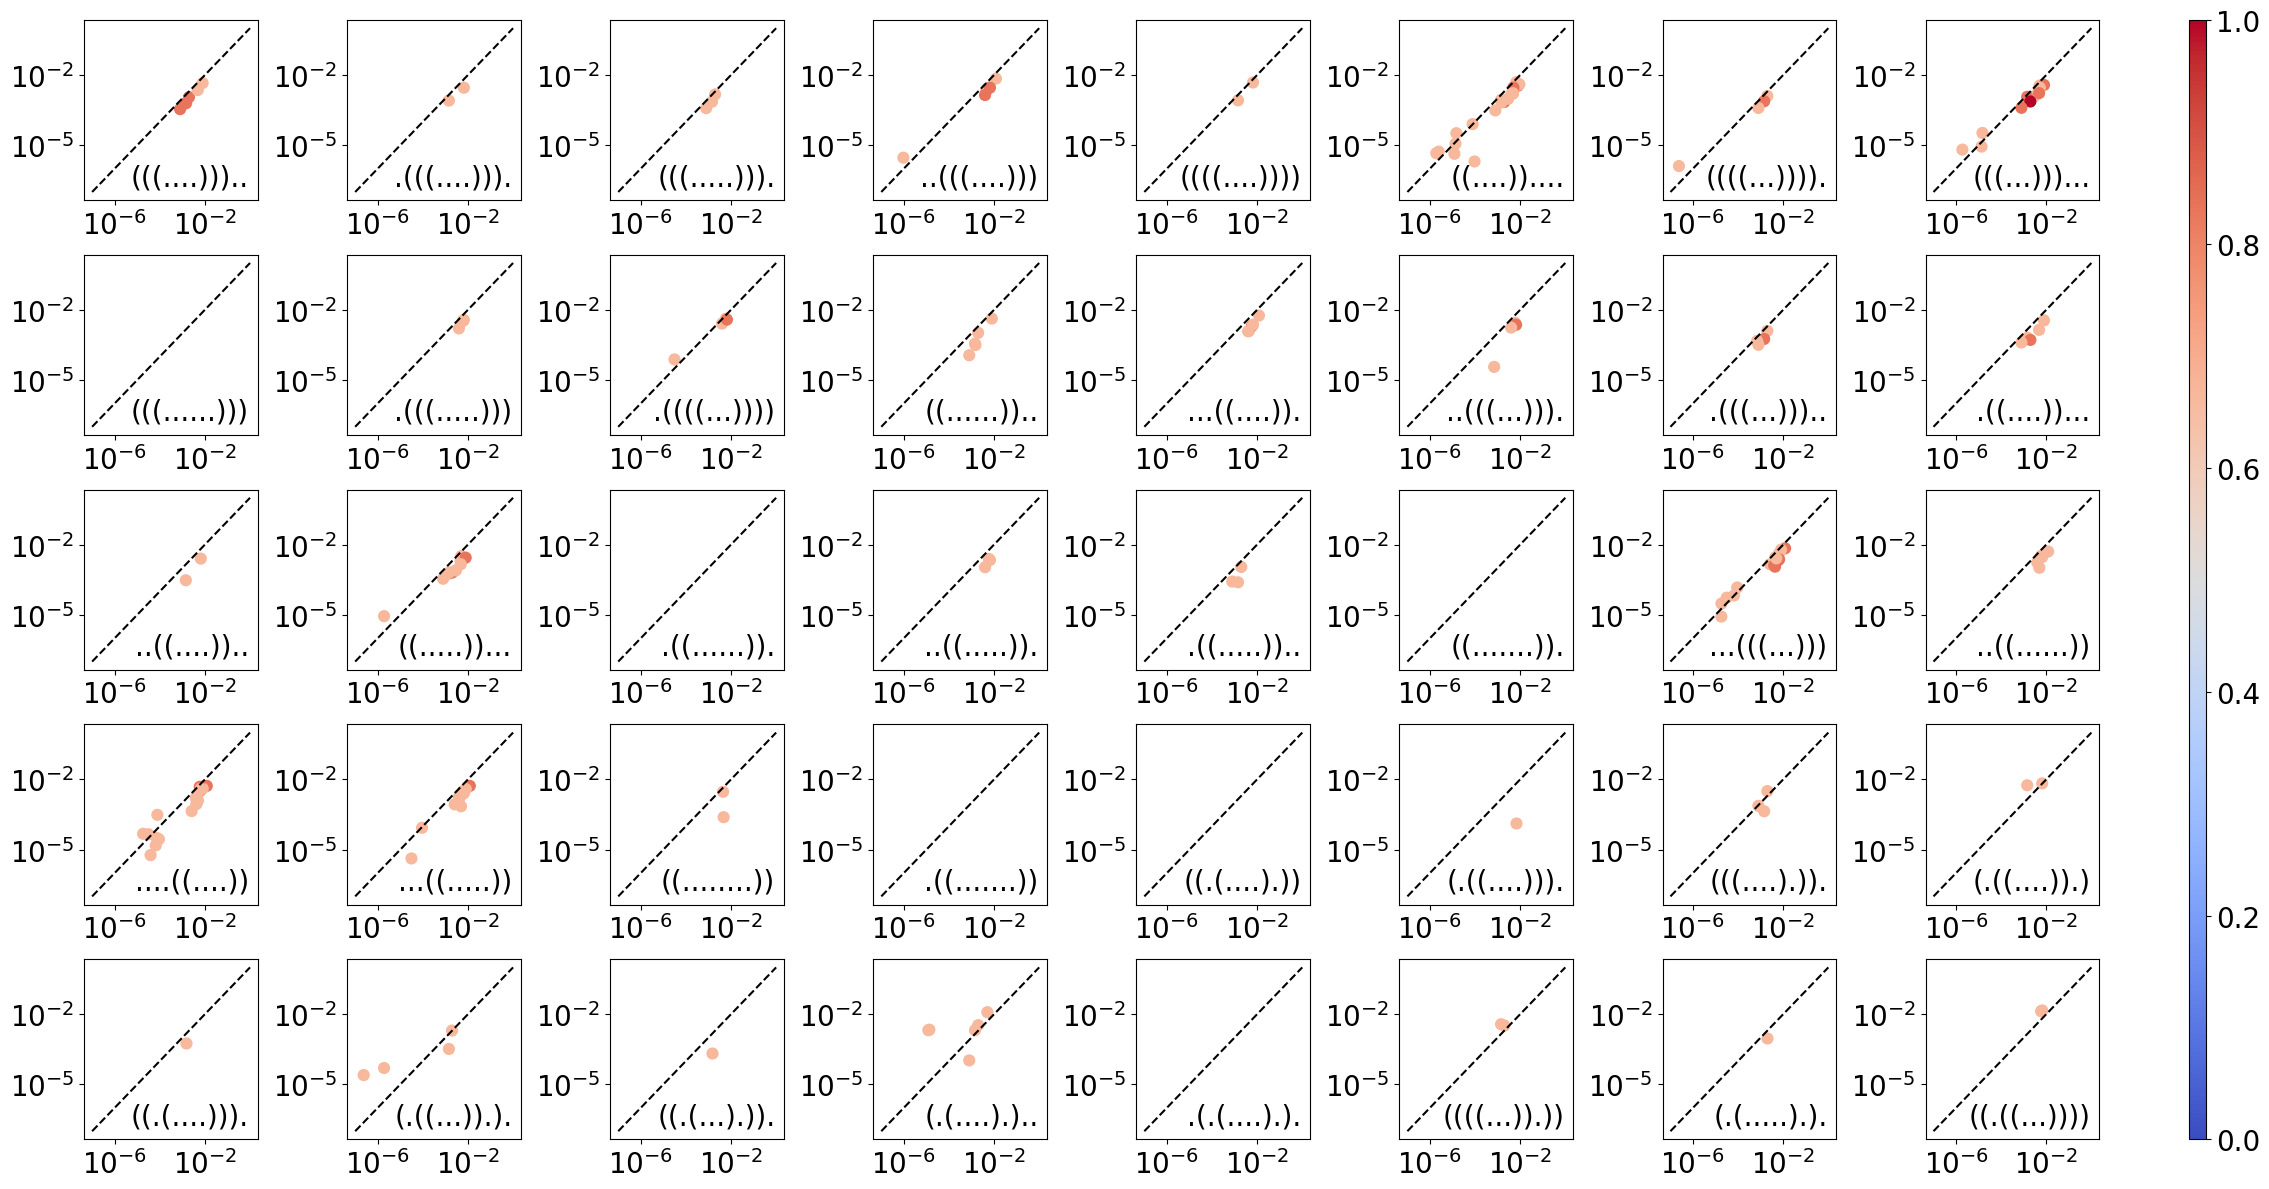

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(5, 9, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.1])

plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

axs = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(8)]

for i, ax in enumerate(axs):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listhamming = []
        listfreq = []
        
        for q, phi in qitems.items():
            if q == '.'*L or q == key:  # Skip the neutral set and the del sequence
                continue
            hammingpq = hamming(key, q)
            if hammingpq > 0.5:
                listphipq.append(phi)
                listhamming.append(hamming(key, q))
                listfreq.append(neutralsets[q+'\n'] / K**L)
        
        scatter = ax.scatter(listfreq, listphipq, s=60, c=listhamming, cmap=cmap, norm=norm, alpha=1)  # Use the colormap to determine the color

        ax.plot([1e-7, 1], [1e-7, 1], color='black', linestyle='--')
        ax.set_xscale("log")
        ax.set_yscale('log')
        ax.set_xticks([1e-6, 1e-2])
        ax.text(0.95, 0.05, key, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_subplot(gs[:, -1])  # Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the colorbar
plt.savefig("phipqlargeH.png", bbox_inches='tight')
plt.savefig("phipqlargeH.eps", bbox_inches='tight')
plt.show()

# Neutral correlations

In [16]:
with open("../data/rhopDPD.pkl","rb") as f:
    rhopDPD = pickle.load(f)
with open("../data/rhopMFE.pkl","rb") as f:
    rhopD= pickle.load(f)
with open("../data/neutralsetsDPD.pkl","rb") as f:
    neutralsetsDPD= pickle.load(f)

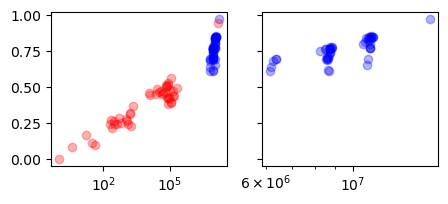

In [37]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(5,2), sharey=True)
ax[0].scatter(list(neutralsetsDPD.values()),list(rhopDPD.values()),color='blue',alpha=0.3)
ax[0].scatter(list(neutralsets.values()),list(rhopD.values()),color='red',alpha=0.3)
ax[0].set_xscale('log')

ax[1].scatter(list(neutralsetsDPD.values()),list(rhopDPD.values()),color='blue',alpha=0.3)
ax[1].set_xscale('log')